In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import sigkernel_cpu as ksig

In [2]:
def psi(x, a=1, C=4):
    # helper function to calculate the normalisation constant for the characteristic signature kernel
    x = C+C**(1+a)*(C**-a - x**-a)/a if x>4 else x
    return x

def norm_func(λ, norms, a=1, c=4):
    '''
    Function to solve for root which are the normalisation constants for the characteristic signature kernel
    λ: float, normalisation constant
    norms: np.array of shape (n_levels,) where n_levels is the number of signature levels
    a: float, parameter for psi function used in the tensor normalisation to get the characteristic signature kernel
    C: float, as above
    '''
    norm_sum = norms.sum()
    m = len(norms)
    λ = np.ones(m) * λ
    powers = np.arange(m) * 2
    return np.sum(norms * np.power(λ, powers)) - psi(norm_sum, a, c)

def get_normalisation_constants(gram_matrix, a=1, C=4):
    '''
    Calculate normalisation constants for each path
    normsq_levels: np.array of shape (n_samples, n_levels) where n_levels is the number of signature levels
    a: float, parameter for psi function used in the tensor normalisation to get the characteristic signature kernel
    C: float, as above
    '''
    normsq_levels = ksig.utils.matrix_diag(gram_matrix).T # shape (n_samples, n_levels) each row is the norm squared of the signature at each level for a sample
    n_samples = normsq_levels.shape[0]
    normsq = np.sum(normsq_levels, axis=1) # shape (n_samples,) each entry is the norm squared of the signature for a sample
    norm_condition = normsq > C # check which samples need normalisation
    λ = np.ones(n_samples)
    for i in range(n_samples):
        if norm_condition[i]:
            λ[i] = brentq(norm_func, 0, 1, args=(normsq_levels[i], a, C)) # find normalisation constant for each sample
    return λ


In [17]:
n_samples = 50
sample_len = 30
initial_value = 100
n_levels = 3
lengthscale = 0.1
dt = 1 / 12
a = 1
C = 100

In [18]:
X = ksig.tests.gen_Heston_path(mu=0.1, v0=0.04, kappa=2., theta=0.04, sigma=0.2, rho=-0.5,
                               dt=dt, n_paths=n_samples, seq_len=sample_len).astype(np.float32) * initial_value
Y = ksig.tests.gen_Heston_path(mu=0.5, v0=0.25, kappa=1., theta=0.25, sigma=0.5, rho=-0.5,
                               dt=dt, n_paths=n_samples, seq_len=sample_len).astype(np.float32) * initial_value
X = np.log(X)
Y = np.log(Y)

In [19]:
static_kernel = ksig.static.kernels.RBFKernel(lengthscale=lengthscale)
kernel = ksig.kernels.SignatureKernel(n_levels=n_levels, order=n_levels, normalization=3, static_kernel=static_kernel)
K_XX = kernel(X, X)
K_YY = kernel(Y, Y)
K_XY = kernel(X, Y)
K_XX.shape, K_YY.shape, K_XY.shape

((4, 50, 50), (4, 50, 50), (4, 50, 50))

In [20]:
K_XX.shape, K_XX.min(), K_XX.max()

((4, 50, 50), -1.730585, 15.573306)

In [21]:
K_YY.shape, K_YY.min(), K_YY.max()

((4, 50, 50), -3.275638, 24.072582)

In [22]:
lambdas = get_normalisation_constants(K_XX, a=a, C=C)
lambdas.shape, lambdas

((50,),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [23]:
lambdas = get_normalisation_constants(K_YY, a=a, C=C)
lambdas.shape, lambdas

((50,),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

# More than one root in range

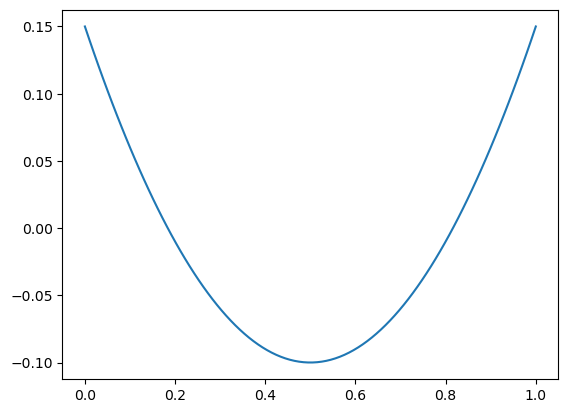

In [50]:
# define function with more than one root between 0 and 1
def f(x):
    return (x-0.5)**2 - 0.1
x = np.linspace(0, 1, 100)
y = f(x)
plt.plot(x, y)

In [51]:
brentq(f, 0, 1)

ValueError: f(a) and f(b) must have different signs